## High percentile precipitation rate - one model + obs

In [18]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from os.path import expanduser
home = expanduser("~")

In [19]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',       # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]

experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]       

folder = home + '/Documents/data/cmip5/ds'
fileName = model + '_precip_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
precip = ds.precip*60*60*24
precip.attrs['units']= 'mm/day'


percentile_options = [
    # 'pr95',
    # 'pr97',
    'pr99',
    # 'pr999',
    ]
percentile_option = percentile_options[0]


folder = home + '/Documents/data/cmip5/' + model
fileName = model + '_pr_percentiles_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
pr_percentile = ds[percentile_option]


obs = {'GPCP':True}
if obs['GPCP']:
    folder = home + '/Documents/data/obs/ds'
    fileName = 'GPCP_precip.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    precip_gpcp = ds.precip

    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_pr_percentiles.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    pr_percentile_gpcp = ds[percentile_option]

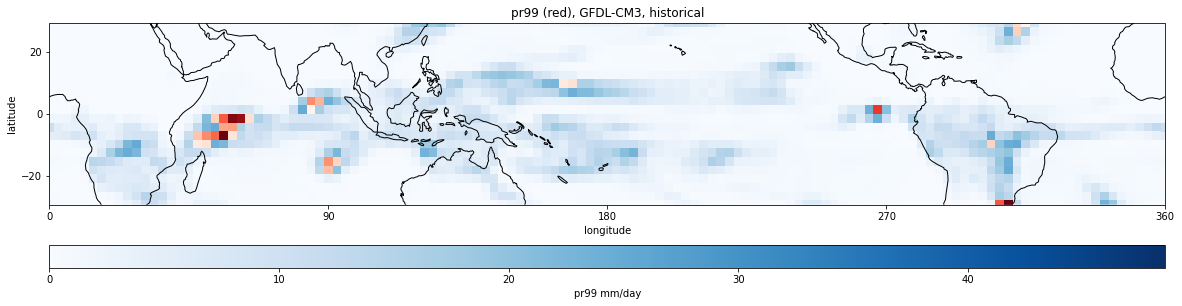

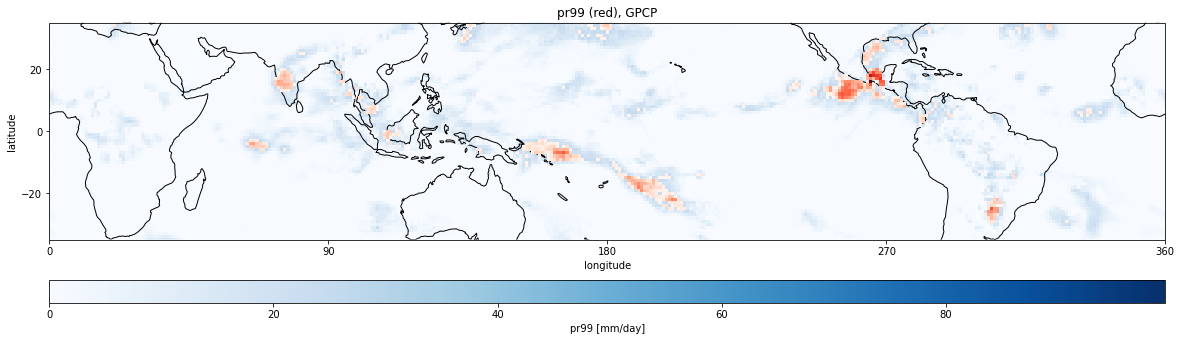

In [20]:
fig= plt.figure(figsize=(20,7.5))
lat = precip.lat
lon = precip.lon
lonm,latm = np.meshgrid(lon,lat)

ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))

ax.add_feature(cfeat.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())

day = 0
pr_day = precip.isel(time=day)
extreme_percentileDay = pr_percentile.isel(time=day).data

pcm= ax.pcolormesh(lonm,latm, pr_day,transform=ccrs.PlateCarree(),zorder=0, cmap='Blues')
ax.pcolormesh(lonm,latm, pr_day.where(pr_day>extreme_percentileDay),transform=ccrs.PlateCarree(), cmap='Reds')

ax.set_title(percentile_option + ' (red), ' + model + ', ' + experiment)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = percentile_option + ' ' + pr_percentile.attrs['units'])


if obs['GPCP']:
    fig= plt.figure(figsize=(20,7.5))
    lat = precip_gpcp.lat
    lon = precip_gpcp.lon
    lonm,latm = np.meshgrid(lon,lat)

    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))

    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())

    day = 0
    pr_day = precip_gpcp.isel(time=day)
    extreme_percentileDay = pr_percentile.isel(time=day).data

    pcm= ax.pcolormesh(lonm,latm, pr_day,transform=ccrs.PlateCarree(),zorder=0, cmap='Blues')
    ax.pcolormesh(lonm,latm, pr_day.where(pr_day>extreme_percentileDay),transform=ccrs.PlateCarree(), cmap='Reds')

    ax.set_title(percentile_option + ' (red), GPCP')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

    ax.set_yticks([-20, 0, 20])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])

    plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = percentile_option + ' [' + pr_percentile.attrs['units'] + ']')

## annual

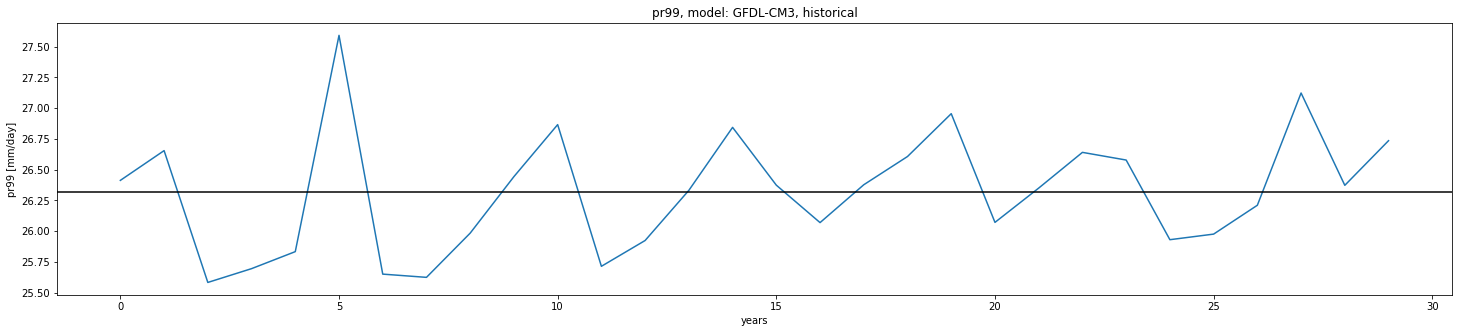

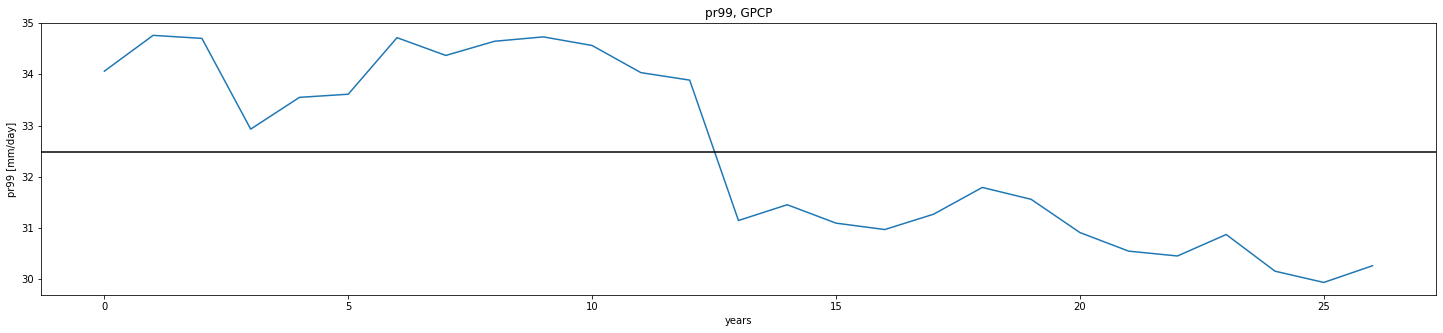

In [21]:
plt.figure(figsize= (25,5))
plt.plot(pr_percentile.resample(time='Y').mean(dim='time'))
plt.title(percentile_option + ', model: ' + model + ', ' + experiment)
plt.ylabel(percentile_option + ' [' + pr_percentile.attrs['units'] + ']')
plt.xlabel('years')
plt.axhline(y=pr_percentile.resample(time='Y').mean(dim='time').mean(dim='time'), color='k')


if obs['GPCP']:
    plt.figure(figsize= (25,5))
    plt.plot(pr_percentile_gpcp.resample(time='Y').mean(dim='time'))
    plt.title(percentile_option + ', GPCP')
    plt.ylabel(percentile_option + ' [' + pr_percentile.attrs['units'] + ']')
    plt.xlabel('years')
    plt.axhline(y=pr_percentile_gpcp.resample(time='Y').mean(dim='time').mean(dim='time'), color='k')

## seasonally

In [22]:
def to_monthly(da):
    year = da.time.dt.year
    month = da.time.dt.month

    # assign new coords
    da = da.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return da.set_index(time=("year", "month")).unstack("time")

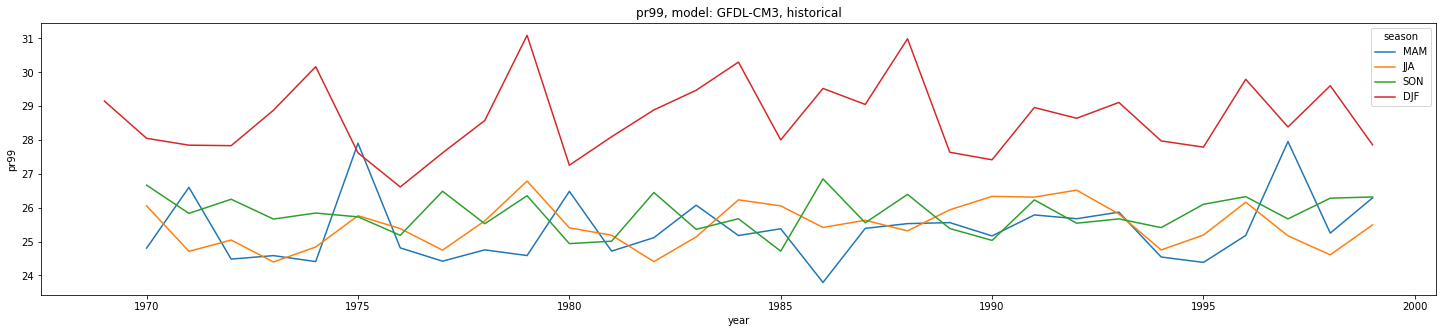

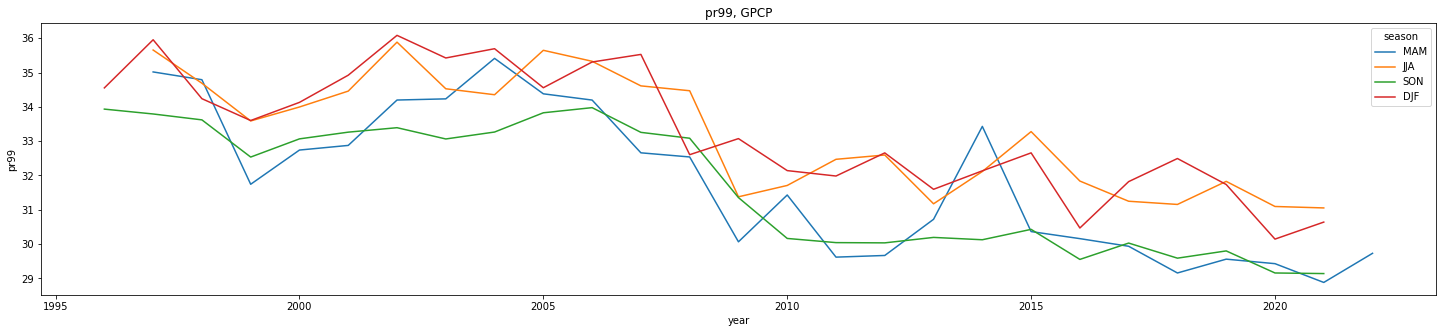

In [23]:
season = pr_percentile.resample(time='QS-DEC').mean(dim="time")
season = to_monthly(season)
# 3 - MAM
# 6 - JJA
# 9 - SON
# 12 - DJF
season = season.rename({'month':'season'})
season = season.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])
season.plot(x='year', hue='season', figsize=(25,5))
plt.title(percentile_option + ', model: ' + model + ', ' + experiment)


if obs['GPCP']:
    season = pr_percentile_gpcp.resample(time='QS-DEC').mean(dim="time")
    season = to_monthly(season)
    # 3 - MAM
    # 6 - JJA
    # 9 - SON
    # 12 - DJF
    season = season.rename({'month':'season'})
    season = season.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])
    season.plot(x='year', hue='season', figsize=(25,5))
    plt.title(percentile_option + ', GPCP')

## monthly

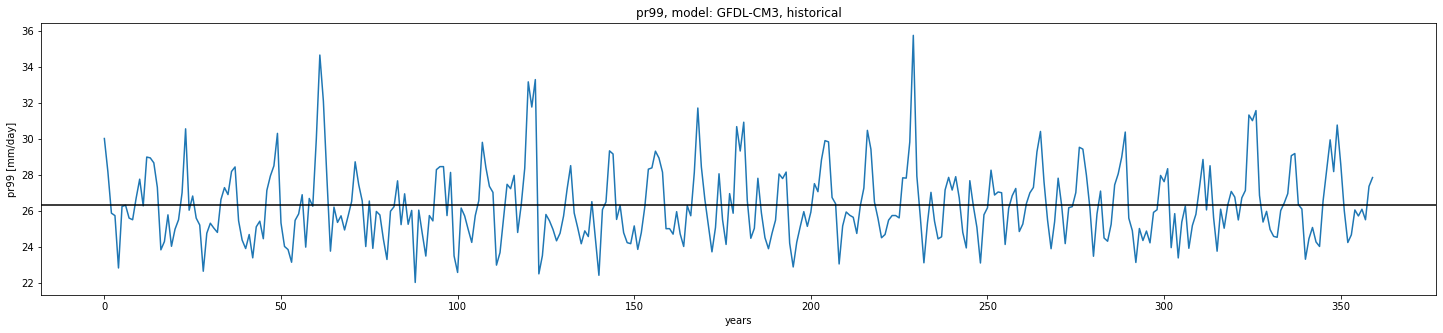

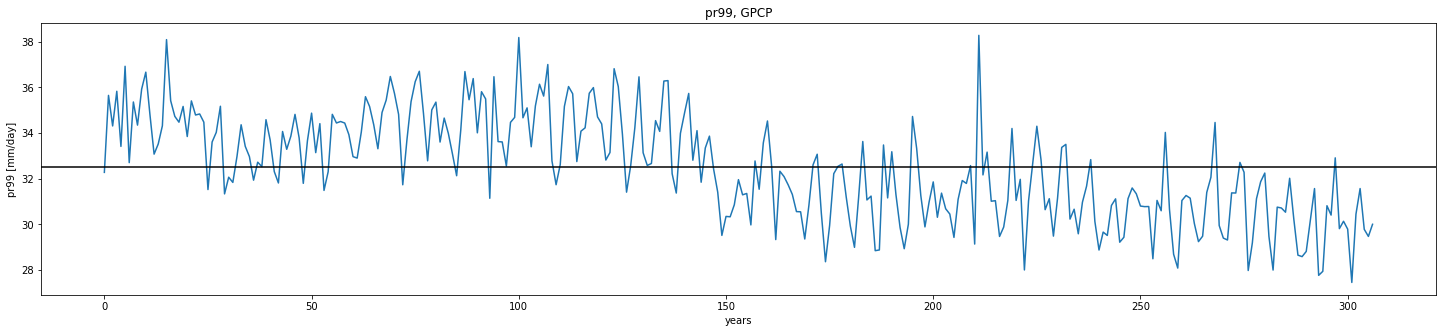

In [24]:
plt.figure(figsize= (25,5))
plt.plot(pr_percentile.resample(time='M').mean(dim='time'))
plt.title(percentile_option + ', model: ' + model + ', ' + experiment)
plt.ylabel(percentile_option + ' [' + pr_percentile.attrs['units'] + ']')
plt.xlabel('years')
plt.axhline(y=pr_percentile.resample(time='M').mean(dim='time').mean(dim='time'), color='k')



if obs['GPCP']:
    plt.figure(figsize= (25,5))
    plt.plot(pr_percentile_gpcp.resample(time='M').mean(dim='time'))
    plt.title(percentile_option + ', GPCP')
    plt.ylabel(percentile_option + ' [' + pr_percentile.attrs['units'] + ']')
    plt.xlabel('years')
    plt.axhline(y=pr_percentile_gpcp.resample(time='M').mean(dim='time').mean(dim='time'), color='k')

## daily

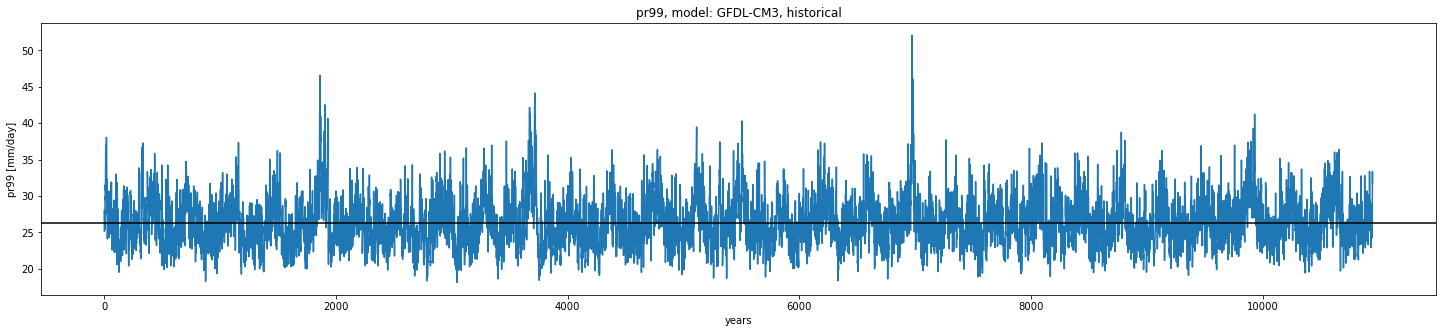

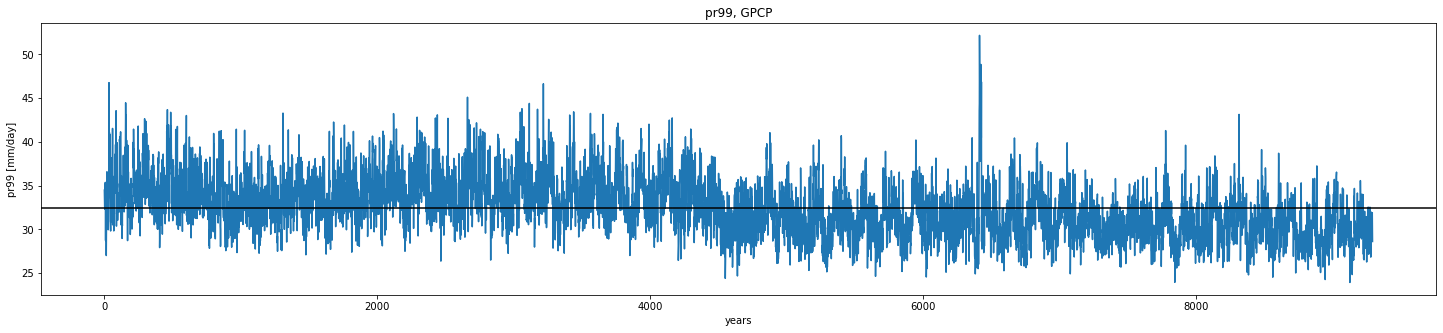

In [25]:
f, ax = plt.subplots(figsize = (25,5))
ax.plot(pr_percentile)
ax.axhline(y=pr_percentile.mean(dim='time'), color='k')
ax.set_title(percentile_option + ', model: ' + model + ', ' + experiment)
#ax.set_ylim(0,100)
ax.set_xlabel('years')
ax.set_ylabel(percentile_option + ' [' + pr_percentile.attrs['units'] + ']')


if obs['GPCP']:
    f, ax = plt.subplots(figsize = (25,5))
    ax.plot(pr_percentile_gpcp)
    ax.axhline(y=pr_percentile_gpcp.mean(dim='time'), color='k')
    ax.set_title(percentile_option + ', GPCP')
    #ax.set_ylim(0,100)
    ax.set_xlabel('years')
    ax.set_ylabel(percentile_option + ' [' + pr_percentile.attrs['units'] + ']')

## other

### monthly mean

In [26]:
monthly = to_monthly(pr_percentile)
monthly = monthly.assign_coords(month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul','aug', 'sep', 'oct', 'nov', 'dec'])

Text(0.5, 1.0, 'pr99, model: GFDL-CM3, historical')

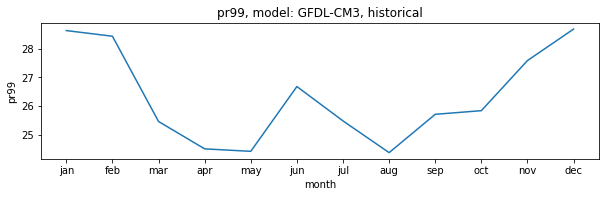

In [27]:
monthly.mean(dim='year').plot(figsize = (10,2.5))
plt.title(percentile_option + ', model: ' + model + ', ' + experiment)